# Deploying a dask cluster for inference of deep neural networks

In [76]:
from typing import Union, Any
from pathlib import Path

import numpy as np
from nptyping import NDArray
from torchtyping import TensorType
import dask
import dask.array as da
import torch 
import matplotlib.pyplot as plt

import dask_image.imread
import dask_image.ndfilters
import dask_image.ndmeasure


%load_ext autoreload
%reload_ext autoreload
%autoreload 2
from dask_utils import load_image, preprocess_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
img_dir = Path("../data/images/vanalleswat")
imgs = [img for img in img_dir.glob("*") if img.suffix in ['.jpg', '.png']]

Lazy-load the images using dask-image

In [32]:
inference_images = dask_image.imread.imread(img_dir / "*")

In [33]:
inference_images

,Array,Chunk
Bytes,9.95 MiB,199.69 kiB
Shape,"(51, 213, 320, 3)","(1, 213, 320, 3)"
Count,153 Tasks,51 Chunks
Type,uint8,numpy.ndarray


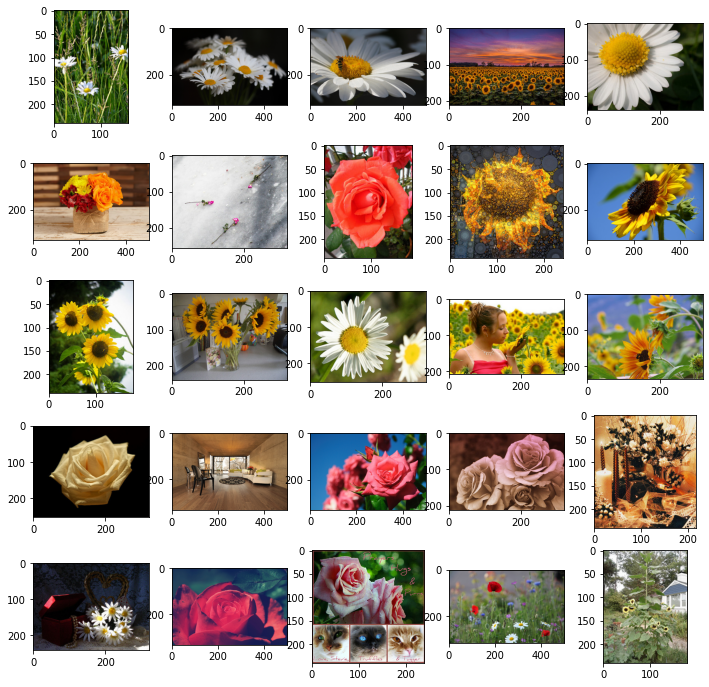

In [36]:
fig, ax = plt.subplots(5, 5, figsize=(12, 12))
ax = ax.ravel()

for ax_idx, ax_sub in enumerate(ax):
    ax_sub.imshow(inference_images[ax_idx])
plt.show()

We can wrap the loading & preprocessing functions in delayed decorators provided by dask to make them lazy.

In [81]:
@dask.delayed
def load_image_wrapper(img_path: Union[Path, str]) -> NDArray[(1, Any, Any, 3), np.uint8]:
    return load_image(img_path)

@dask.delayed
def preprocess_image_wrapper(img: NDArray[(Any, Any, 3), np.uint8]) -> TensorType[3, 224, 224, torch.float64]:
    return preprocess_image(img)

In [82]:
imgs_delayed = [load_image_wrapper(img) for img in imgs]

In [83]:
imgs_preprocessed = [preprocess_image_wrapper(img) for img in imgs_delayed]

In [84]:
imgs_preprocessed[0].compute().shape

torch.Size([3, 224, 224])